In [58]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [59]:
import numpy as np
import pylab as plt
import torch
import scipy.stats.distributions as dist


import swyft
DEVICE = 'gpu' if torch.cuda.is_available() else 'cpu'

In [60]:
SIGMA = 0.1

In [61]:
class SimulatorBlob(swyft.Simulator):
    def __init__(self, bounds = None, Npix = 64, sigma = None):
        super().__init__()
        self.transform_samples = swyft.to_numpy32
        self.theta_sampler = swyft.RectBoundSampler([dist.uniform(4.00, 0.001)])
        self.bounds = bounds
        self.Npix = Npix
#        self.sigma = sigma
        self.powersampler = swyft.utils.PowerSpectrumSampler2((Npix, Npix))
        self.sigma = torch.ones(Npix, Npix)*SIGMA
        self.sigma[:,:Npix//2] *= 1

    def get_pk_fn(self, theta):
        return lambda k: 1e-3*(k+0.05)**-theta[0]
        
    def sample_delta(self, pk_fn, use_bounds = True):
        if self.bounds is not None and use_bounds:
            i = np.random.randint(len(self.bounds))
            return torch.tensor(self.bounds[i])
        else:
#            return self.powersampler.sample(lambda k: 1e6*3*(k/0.5)**-theta[0])
            return self.powersampler.sample(pk_fn)

    def psf(self, rho):
#        return rho
        kernel = torch.ones(1, 1, 3, 3)/3**2
        return torch.nn.functional.conv2d(rho.unsqueeze(0).unsqueeze(0), kernel, padding = 1).squeeze(0).squeeze(0)
            
    def build(self, graph):
        theta = graph.node("theta", self.theta_sampler)
        pk_fn = graph.node("pk_fn", self.get_pk_fn, theta)
        delta = graph.node("delta", self.sample_delta, pk_fn)
#        delta_unbound = graph.node("delta_unbound", lambda pk_fn: self.sample_delta(pk_fn, use_bounds = False), pk_fn)
#        rho = graph.node("rho", lambda delta: torch.exp(delta/5), delta)
#        rho = graph.node('rho', lambda delta: np.exp(self.psf(delta)*0.5), delta)
        rho = graph.node('rho', lambda delta: self.psf(np.exp(delta*2)-1)*0.5, delta)
        x = graph.node("x", lambda rho: rho + torch.randn(self.Npix, self.Npix)*self.sigma, rho)
#        x = graph.node("x", lambda delta: delta + torch.randn(self.Npix, self.Npix)*self.sigma, delta)
#        z = graph.node("test", lambda: lambda x: x)

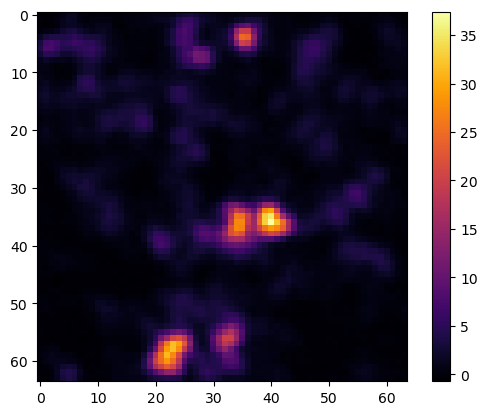

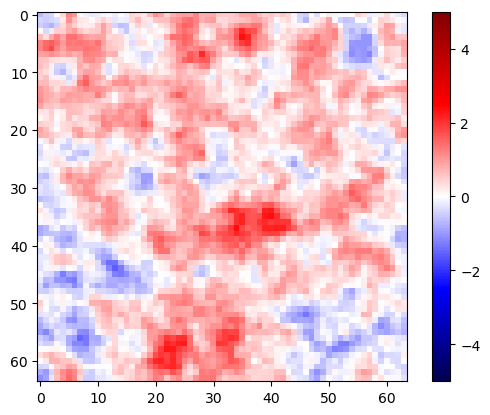

0.38039988


0.6136437

In [62]:
NPIX = 64
sim = SimulatorBlob(Npix = NPIX)
sample0 = sim.sample(conditions = dict(theta = np.array([4.])))
del sample0['pk_fn']
plt.imshow(sample0['x'], cmap = 'inferno')
plt.colorbar()
plt.show()
plt.imshow(sample0['delta'], vmin = -5, vmax = 5, cmap = 'seismic')
plt.colorbar()
plt.show()
print(sample0['delta'].mean())
sample0['delta'].std()

In [63]:
SIGMA = sim.sigma.numpy()
def hook(sample):
#    print(sample)
    sample['x'] = sample['rho'] + np.random.randn(*sample['delta'].shape)*SIGMA
    return sample

The logic is the following:

We approximate the precision matrix of the inference problem like
$$
Q = W^T A^T D A W
$$
where $W$ is a wavelet transform, $A$ corresponds to correlations, and $D$ is a diagonal matrix.

As a starting point, I can assume that $W$ and $A$ are unit matrices.

For the loss function, we need independent noise realisations $n$, ideally such that $n^T (Q+\Sigma_{prior}^{-1}) n$ is low-variance.

Default could be just Gaussian random noise for now. Otherwise random prior draws.

In [64]:
samples = sim.sample(64*64*4, exclude = ['pk_fn'])
pk0 = sim.sample()['pk_fn']

  0%|          | 0/16384 [00:00<?, ?it/s]

In [65]:
samples[0].keys()

dict_keys(['theta', 'delta', 'rho', 'x'])

In [66]:
class Atom(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.c = torch.nn.Conv2d(1, 1, 9, padding = 4, bias = False)
        self.c.weight = torch.nn.Parameter(torch.ones_like(self.c.weight))
        self.cT = torch.nn.ConvTranspose2d(1, 1, 9, padding = 4, bias = False)
    
    def __call__(self, x):
        return self.c(x.unsqueeze(1)).squeeze(1)
    
    def transpose(self, x):
        self.cT.weight = self.c.weight
        return self.cT(x.unsqueeze(1)).squeeze(1)

In [85]:
SCALE = 0.00

class L(torch.nn.Module):
    def __init__(self, logD, W = None, W_T = None, A = None, A_T = None, Q_prior = None):
        super().__init__()
        self.logD = torch.nn.Parameter(logD)
        self.W = W if W else lambda x: x 
        self.W_T = W_T if W else lambda x: x 
        self.Atom = Atom()
        self.A = A if A else lambda x: x
        self.A_T = A_T if A else lambda x: x
        self.A = lambda x: self.Atom(x)
        self.A_T = lambda x: self.Atom.transpose(x)
        self.Q_prior = Q_prior if Q_prior else lambda x: x*0

        
    @property
    def D(self):
        """Returns diagonal components of D."""
        return torch.exp(self.logD)
    
    def Q(self, x, b_est):
        """Applies Q = W.T A.T D A W."""
        x = self.A(x)
        #x = torch.exp(b_est.detach()*self.logD[1].view(NPIX, NPIX)*0.1+self.logD[0].view(NPIX, NPIX).unsqueeze(0))*x
        x = torch.exp(b_est.detach()*self.logD[1,0]*SCALE+self.logD[0,0])*x
#        x = self.W(x)
#        x = self.D*x
#        x = self.W_T(x)
        x = self.A_T(x)
        return x
    
    def __call__(self, b_est, z):
        N = torch.randn_like(z)*z.std()
        loss = 0.5*((self.Q(z, b_est)+self.Q_prior(z)-b_est)*N)**2 - (self.Q(N, b_est)+self.Q_prior(N))*N
        loss = loss.reshape(-1)
        return swyft.AuxLoss(loss, 'x')

In [77]:
class Network(swyft.AdamWReduceLROnPlateau, swyft.SwyftModule):
    def __init__(self):
        super().__init__()
        self.learning_rate = 3e-2
        self.early_stopping_patience = 10000
        W = torch.nn.Flatten(1, 2)
        W_T = torch.nn.Unflatten(1, (NPIX, NPIX))
        UT, D, U = sim.powersampler.covariance_decomposition(pk0)
        self.D = torch.nn.Parameter(D, requires_grad = False)
        prior_Q = lambda x: UT(U(x)/self.D)
        logD_init = torch.zeros(2, NPIX*NPIX)
        logD_init[0,:] = -3
        self.L = L(logD_init, W = W, W_T = W_T, Q_prior = prior_Q)
        
        self.receptor = torch.nn.Sequential(
            torch.nn.Unflatten(0, (-1, 1)),
            torch.nn.Conv2d(1, 1, 9, padding=4),
            torch.nn.Flatten(0, 1)
        )
        self.map1 = torch.nn.Sequential(
            torch.nn.Unflatten(0, (-1, 1)),
            torch.nn.Conv2d(1, 16, 1, padding=0),
            torch.nn.ReLU(),
            torch.nn.Conv2d(16, 16, 1, padding=0),
            torch.nn.ReLU(),
            torch.nn.Conv2d(16, 1, 1, padding=0),
            torch.nn.Flatten(0, 1)
        )
        self.map2 = torch.nn.Sequential(
            torch.nn.Unflatten(0, (-1, 1)),
            torch.nn.Conv2d(1, 16, 1, padding=0),
            torch.nn.ReLU(),
            torch.nn.Conv2d(16, 16, 1, padding=0),
            torch.nn.ReLU(),
            torch.nn.Conv2d(16, 1, 1, padding=0),
            torch.nn.Flatten(0, 1)
        )
        
    def estimator1(self, x):
        x = self.receptor(x)
        x = self.map1(x) + x
        x = self.map2(x) + x
        return x

    def forward(self, A, B):
        x = A['x']
        b_est = self.estimator1(x)
        z = B['delta'][:len(x)]
        return self.L(b_est, z)

In [78]:
trainer = swyft.SwyftTrainer(accelerator = DEVICE, precision = 64, max_epochs = 20)
dm = swyft.SwyftDataModule(samples, batch_size=64, on_after_load_sample=hook)
network = Network()
trainer.fit(network, dm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type       | Params
----------------------------------------
0 | L        | L          | 8.4 K 
1 | receptor | Sequential | 82    
2 | map1     | Sequential | 321   
3 | map2     | Sequential | 321   
----------------------------------------
9.1 K     Trainable params
4.1 K     Non-tra

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


Reloading best model: /gpfs/home2/weniger/swyft/notebooks/dev/lightning_logs/version_4529222/checkpoints/epoch=17-step=3690-v2.ckpt


0.014710327094564253
tensor([[1.8083, 1.6417, 1.6417,  ..., 1.6417, 1.6417, 1.6417],
        [0.9823, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],
       dtype=torch.float64, grad_fn=<PowBackward0>)
1.3208756067757845 0.320904856256383


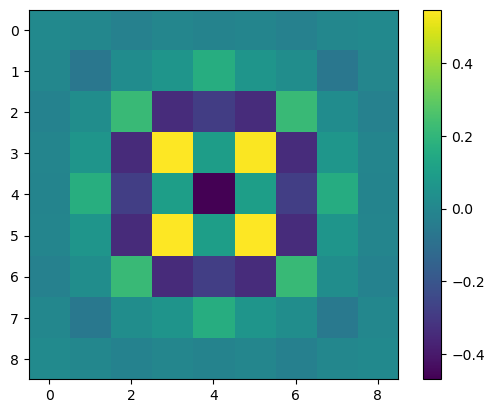

In [82]:
network.cpu()
kernel = network.receptor[1].weight.detach().numpy()[0,0]
print(kernel.sum())
plt.imshow(kernel)
print(network.L.D**-0.5)
print((network.L.D**-0.5).mean().item(), (network.L.D**-0.5).std().item())
plt.colorbar()

The GEDA sampler should directly provide noise sampels from the images, without intermediate steps or transformations.

- $U_2$, $D_2$ and $U_2^T$ are all defined in real space, going from $(N, N, N) \rightarrow (N*N*N,)$ and back
- The same is true for $G_1$ etc.

Consequences for GEDA:
- $\theta$ is in image space (updated according to coupling-strength constrained prior)
- $u_1$ is in in image space (updated according to coupling strength)
- $u_2$ is in vector space of $Q_1$ (updated according to likelihood precision)

tensor(2.5313, dtype=torch.float64)

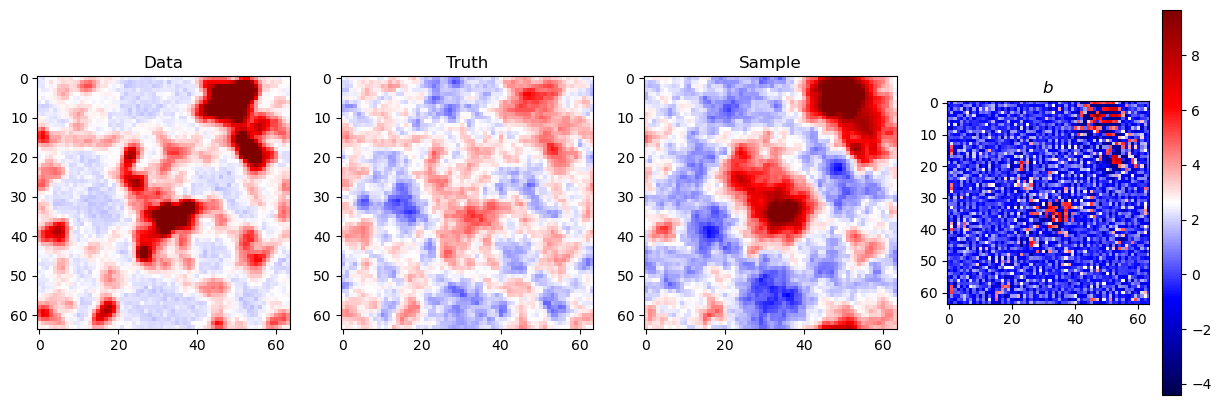

In [83]:
#pk = sim.sample()['pk_fn']
U2T, invD2, U2 = sim.powersampler.covariance_decomposition(pk0)
D2 = 1/invD2

GAMMA = 1


G1 = torch.nn.Flatten(-2)
G1T = torch.nn.Unflatten(-1, (NPIX, NPIX))
G1 = lambda x: network.L.W(network.L.A(x.unsqueeze(0))).squeeze(0).detach()
G1T = lambda x: network.L.A_T(network.L.W_T(x.unsqueeze(0))).squeeze(0).detach()

i = 3
x = torch.tensor(samples[i]['x']).double()
d = torch.tensor(samples[i]['delta']).double()
b_est = network.estimator1(x.unsqueeze(0)).squeeze(0).cpu().detach()*GAMMA
#d_est = network.estimator2(x.unsqueeze(0)).squeeze(0).cpu().detach()*0.1
mu = b_est
#D1 = torch.exp(d_est*0).flatten()
D1 = torch.exp(network.L.logD[0,0].detach().cpu() + SCALE*b_est.flatten()*network.L.logD[1,0]).detach()*GAMMA

sampler = swyft.utils.GEDASampler2(1e-2, G1, D1, G1T, U2, D2, U2T, out_shape = (NPIX, NPIX), mu = mu)
s = sampler.sample(1, steps=1000, initialize_with_Q2=True)
plt.figure(figsize = (15, 5))
plt.subplot(141)
plt.title("Data")
plt.imshow(x, vmin = -5, vmax = 5, cmap = 'seismic')
plt.subplot(142)
plt.title("Truth")
plt.imshow(d, vmin = -5, vmax = 5, cmap = 'seismic')
plt.subplot(143)
plt.title("Sample")
plt.imshow(s[0], vmin = -5, vmax = 5, cmap = 'seismic')
plt.subplot(144)
plt.title("$b$")
plt.imshow(mu, cmap = 'seismic')
plt.colorbar()
s[0].std()/d.std()

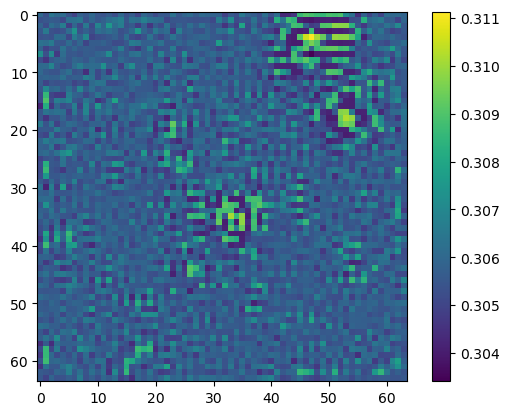

In [84]:
plt.imshow(D1.view(NPIX, NPIX))
plt.colorbar()

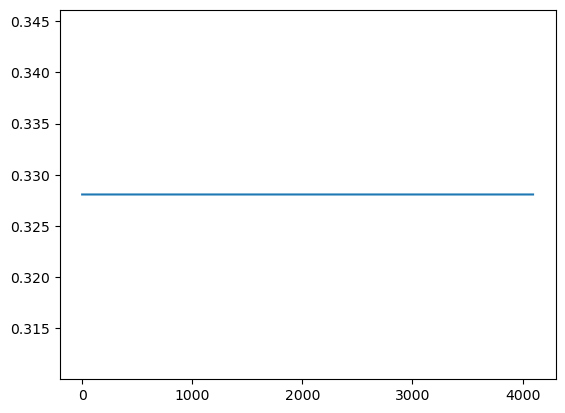

In [36]:
plt.plot(D1)

IndexError: list index out of range

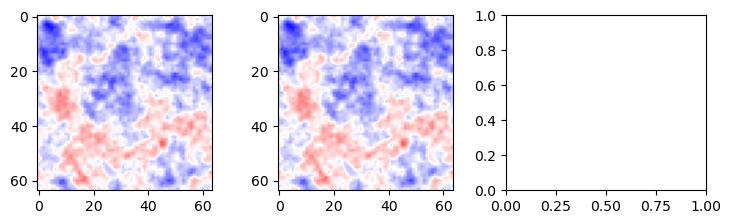

In [16]:
plt.figure(figsize = (15, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(s[i-1], vmin = -5, vmax = 5, cmap = 'seismic')

In [ ]:
plt.hist(np.log(1/D1));